In [37]:
# ===== Cell 1 : Imports généraux et configuration =====

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import torch
from pomegranate.distributions import Categorical
from pomegranate.hmm import DenseHMM

import sys
sys.path.append("../code")  # pour pouvoir faire "from duree import duree"
from duree import duree

plt.style.use("seaborn-v0_8")

In [38]:
# ===== Cell 2 : Chargement des données de pluie mesurées =====

mat = sio.loadmat("../data/RR5MN.mat")
ObsMesure = mat["Support"].astype(np.int8).squeeze() - 1   # 0 = sec, 1 = pluie

N = len(ObsMesure)
freq_rain = np.mean(ObsMesure == 1)
freq_dry  = np.mean(ObsMesure == 0)

print(f"Longueur de la série mesurée : {N}")
print(f"Fréquence empirique de pluie : {freq_rain}")
print(f"Fréquence empirique de sec   : {freq_dry}")

# Durées des périodes sèches / pluvieuses (mesurées)
dSecMes, dPluieMes, pdfSecMes, pdfPluieMes, binsSecMes, binsPluieMes = duree(ObsMesure)

print()
print(f"Nombre de périodes sèches (mesurées)     : {len(dSecMes)}")
print(f"Nombre de périodes pluvieuses (mesurées) : {len(dPluieMes)}")
print()
print(f"Durée moyenne d'une période sèche (mesurée)    : {dSecMes.mean()}")
print(f"Durée moyenne d'une période pluvieuse (mesurée): {dPluieMes.mean()}")

Longueur de la série mesurée : 219168
Fréquence empirique de pluie : 0.04193130383997664
Fréquence empirique de sec   : 0.9580686961600233

Nombre de périodes sèches (mesurées)     : 1595
Nombre de périodes pluvieuses (mesurées) : 1596

Durée moyenne d'une période sèche (mesurée)    : 124.7153605015674
Durée moyenne d'une période pluvieuse (mesurée): 5.758145363408521


In [39]:
# ===== Cell 3 : Fonctions utilitaires =====

def centers_from_bins(bins):
    """Convertit les bords des bins en centres (pour bar plots)."""
    return (bins[:-1] + bins[1:]) / 2


def simulate_hmm(T, B, pi0, N, seed=None):
    """
    Simulation d'un HMM à 3 états avec émissions discrètes {0,1}.
    
    - T : matrice de transition (3x3)
    - B : matrice d'émission (3x2)
          B[i, 0] = P(obs = 0 | état i)
          B[i, 1] = P(obs = 1 | état i)
    - pi0 : distribution initiale (taille 3)
    - N : longueur de la séquence
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
        choice = rng.choice
    else:
        choice = np.random.choice

    states = np.zeros(N, dtype=int)
    obs    = np.zeros(N, dtype=int)

    # État initial
    states[0] = choice([0, 1, 2], p=pi0)
    obs[0]    = choice([0, 1], p=B[states[0]])

    # Évolution
    for t in range(1, N):
        i = states[t-1]
        states[t] = choice([0, 1, 2], p=T[i])
        obs[t]    = choice([0, 1], p=B[states[t]])

    return obs, states

In [40]:
# ===== Cell 4 : Définition du HMM à 3 états (modèle 1, préliminaire) =====

# États cachés :
# E0 = Clear Sky     (ciel clair)
# E1 = Cloudy        (nuageux)
# E2 = Very Cloudy   (très nuageux)
#
# Observations :
# 0 = sec, 1 = pluie

# -----------------------------
# A) MATRICE DE TRANSITION T_init
# -----------------------------
# !!! A REMPLACER par les valeurs de l'énoncé !!!
T_init = np.array([
    [0.90, 0.09, 0.01],   # depuis E0
    [0.20, 0.60, 0.20],   # depuis E1
    [0.05, 0.25, 0.70]    # depuis E2
], dtype=float)

# -----------------------------
# B) MATRICE D'ÉMISSION B_init
# -----------------------------
# B[i,0] = P(obs=0 | état i)  (sec)
# B[i,1] = P(obs=1 | état i)  (pluie)
#
# Ciel clair : pluie quasi impossible
# Très nuageux : pluie très probable
# Nuageux : intermédiaire
# !!! A REMPLACER par les valeurs de l'énoncé !!!
B_init = np.array([
    [1.00, 0.00],   # E0 : Clear Sky
    [0.80, 0.20],   # E1 : Cloudy
    [0.20, 0.80]    # E2 : Very Cloudy
], dtype=float)

# -----------------------------
# C) DISTRIBUTION INITIALE pi0
# -----------------------------
# !!! A REMPLACER par les valeurs de l'énoncé !!!
pi0_init = np.array([0.8, 0.15, 0.05], dtype=float)

print("Matrice de transition initiale T_init =\n", T_init)
print("\nMatrice d'émission initiale B_init =\n", B_init)
print("\nDistribution initiale pi0_init =", pi0_init)
print("\nSommes des lignes de T_init :", T_init.sum(axis=1))
print("Sommes des lignes de B_init :", B_init.sum(axis=1))

Matrice de transition initiale T_init =
 [[0.9  0.09 0.01]
 [0.2  0.6  0.2 ]
 [0.05 0.25 0.7 ]]

Matrice d'émission initiale B_init =
 [[1.  0. ]
 [0.8 0.2]
 [0.2 0.8]]

Distribution initiale pi0_init = [0.8  0.15 0.05]

Sommes des lignes de T_init : [1. 1. 1.]
Sommes des lignes de B_init : [1. 1. 1.]


In [41]:
# ===== Cell 5 : Distribution stationnaire et fréquence moyenne de pluie (modèle 1) =====

# On résout : pi* (3) avec pi* = pi* T, somme(pi*) = 1
A = (T_init.T - np.eye(3))
b = np.zeros(3)
# Remplace la 3e équation par la contrainte de normalisation
A[-1, :] = 1.0
b[-1]    = 1.0

pi_star_3 = np.linalg.solve(A, b)
pi_star_3 = np.clip(pi_star_3, 0, 1)
pi_star_3 /= pi_star_3.sum()

# Probabilité stationnaire de pluie = somme sur les états cachés de :
# P(état i en stationnarité) * P(pluie | état i)
p_rain_stationary_model1 = float(pi_star_3 @ B_init[:, 1])

print("pi* (modèle 1) =", pi_star_3)
print("Probabilité stationnaire de pluie (modèle 1) :", p_rain_stationary_model1)
print("Fréquence empirique de pluie (mesurée)      :", freq_rain)

pi* (modèle 1) = [0.57613169 0.24279835 0.18106996]
Probabilité stationnaire de pluie (modèle 1) : 0.19341563786008223
Fréquence empirique de pluie (mesurée)      : 0.04193130383997664


In [42]:
# ===== Cell 6 : Simulation du modèle 1 et durées sèche/pluie =====

Nsamples = N  # même longueur que la série mesurée pour comparaison

obs_sim1, states_sim1 = simulate_hmm(T_init, B_init, pi0_init, Nsamples, seed=0)

freq_rain_sim1 = np.mean(obs_sim1 == 1)
print("Fréquence de pluie simulée (modèle 1) :", freq_rain_sim1)

dSecSim1, dPluieSim1, pdfSecSim1, pdfPluieSim1, binsSecSim1, binsPluieSim1 = duree(obs_sim1)

print()
print(f"Nombre de périodes sèches (simulées, modèle 1)     : {len(dSecSim1)}")
print(f"Nombre de périodes pluvieuses (simulées, modèle 1) : {len(dPluieSim1)}")
print()
print(f"Durée moyenne d'une période sèche (simulée, mod.1)    : {dSecSim1.mean()}")
print(f"Durée moyenne d'une période pluvieuse (simulée, mod.1): {dPluieSim1.mean()}")

Fréquence de pluie simulée (modèle 1) : 0.1923045335085414

Nombre de périodes sèches (simulées, modèle 1)     : 19807
Nombre de périodes pluvieuses (simulées, modèle 1) : 19808

Durée moyenne d'une période sèche (simulée, mod.1)    : 8.93593174130358
Durée moyenne d'une période pluvieuse (simulée, mod.1): 2.1277766558966076


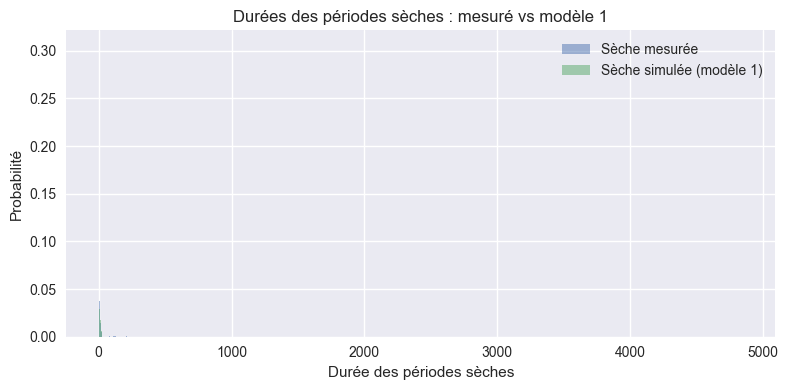

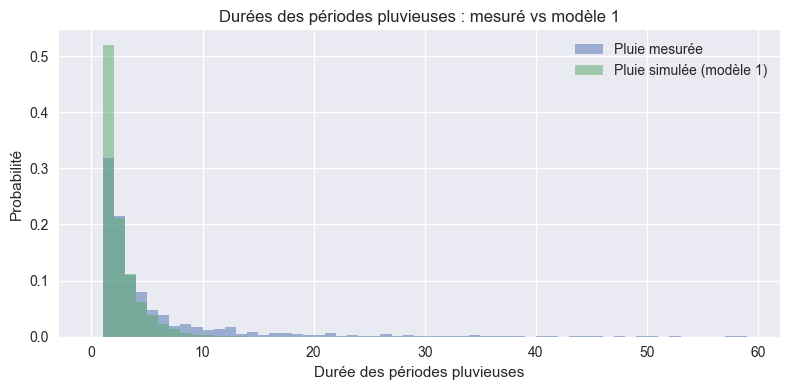

In [43]:
# ===== Cell 7 : Graphiques des durées - modèle 1 vs mesuré =====

# Centres de bins
centersSecSim1   = centers_from_bins(binsSecSim1)
centersSecMes    = centers_from_bins(binsSecMes)
centersPluieSim1 = centers_from_bins(binsPluieSim1)
centersPluieMes  = centers_from_bins(binsPluieMes)

# Durées sèches
plt.figure(figsize=(8, 4))
plt.bar(centersSecMes, pdfSecMes, width=1, alpha=0.5, label="Sèche mesurée")
plt.bar(centersSecSim1, pdfSecSim1, width=1, alpha=0.5, label="Sèche simulée (modèle 1)")
plt.xlabel("Durée des périodes sèches")
plt.ylabel("Probabilité")
plt.title("Durées des périodes sèches : mesuré vs modèle 1")
plt.legend()
plt.tight_layout()
plt.show()

# Durées pluvieuses
plt.figure(figsize=(8, 4))
plt.bar(centersPluieMes, pdfPluieMes, width=1, alpha=0.5, label="Pluie mesurée")
plt.bar(centersPluieSim1, pdfPluieSim1, width=1, alpha=0.5, label="Pluie simulée (modèle 1)")
plt.xlabel("Durée des périodes pluvieuses")
plt.ylabel("Probabilité")
plt.title("Durées des périodes pluvieuses : mesuré vs modèle 1")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# ===== Cellule A : Modèle 2 - HMM à 3 états pour l'apprentissage =====

from pomegranate.distributions import Categorical
from pomegranate.hmm import DenseHMM

# On suppose que B_init est de taille (3,2) et T_init de taille (3,3)
# avec les valeurs choisies (ou imposées) par l'énoncé.

d0 = Categorical([[B_init[0, 0], B_init[0, 1]]])
d1 = Categorical([[B_init[1, 0], B_init[1, 1]]])
d2 = Categorical([[B_init[2, 0], B_init[2, 1]]])

distributions = [d0, d1, d2]

model2 = DenseHMM(
    distributions,
    edges=T_init,
    starts=pi0_init,
    ends=[0.0, 0.0, 0.0],
    max_iter=20,
    verbose=True
)

print(model2)

DenseHMM(
  (start): Silent()
  (end): Silent()
  (distributions): ModuleList(
    (0-2): 3 x Categorical()
  )
)


In [ ]:
# ===== Cellule B : Apprentissage Baum-Welch sur la série mesurée =====

import torch
import numpy as np

# ObsMesure : vecteur 0/1 de longueur N (déjà défini dans la partie 1)
X_train = ObsMesure.reshape(1, -1, 1)        # (batch=1, T, 1)
X_train_torch = torch.from_numpy(X_train).long()

# Lancement de Baum–Welch
model2.fit(X_train_torch)

print("Apprentissage modèle 2 terminé.")

[1] Improvement: nan, Time: 2.614s
[2] Improvement: nan, Time: 2.59s
[2] Improvement: nan, Time: 2.59s
[3] Improvement: nan, Time: 2.583s
[3] Improvement: nan, Time: 2.583s
[4] Improvement: nan, Time: 2.65s
[4] Improvement: nan, Time: 2.65s
[5] Improvement: nan, Time: 2.733s
[5] Improvement: nan, Time: 2.733s
[6] Improvement: nan, Time: 2.624s
[6] Improvement: nan, Time: 2.624s
[7] Improvement: nan, Time: 2.626s
[7] Improvement: nan, Time: 2.626s
[8] Improvement: nan, Time: 2.739s
[8] Improvement: nan, Time: 2.739s
[9] Improvement: nan, Time: 2.715s
[9] Improvement: nan, Time: 2.715s
[10] Improvement: nan, Time: 2.731s
[10] Improvement: nan, Time: 2.731s
[11] Improvement: nan, Time: 2.684s
[11] Improvement: nan, Time: 2.684s
[12] Improvement: nan, Time: 2.643s
[12] Improvement: nan, Time: 2.643s
[13] Improvement: nan, Time: 2.645s
[13] Improvement: nan, Time: 2.645s
[14] Improvement: nan, Time: 2.643s
[14] Improvement: nan, Time: 2.643s
[15] Improvement: nan, Time: 2.708s
[15] Improvem

In [ ]:
# ===== Cellule C : Récupération robuste de T2, B2, pi0_2 =====

def safe_normalize_rows(M, eps=1e-12):
    """Normalise les lignes de M en évitant les divisions par zéro."""
    M = np.asarray(M, dtype=float)
    row_sums = M.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0.0] = eps
    return M / row_sums

# forward_backward renvoie :
#   - transitions : "compteurs" attendus des transitions entre états
#   - posteriors  : gamma_t(i) = P(S_t = i | données)
transitions, posteriors = model2.forward_backward(X_train_torch)

# Compteurs de transitions entre états (3x3)
T_counts = transitions[0, 0].detach().numpy()
T_learned = safe_normalize_rows(T_counts)

# Compteurs de symboles émis par chaque état
gamma = posteriors[0].detach().numpy()   # shape (N, 3)
K = 2                                    # 0 = sec, 1 = pluie
B_counts = np.zeros((3, K))

for t, y in enumerate(ObsMesure):
    B_counts[:, y] += gamma[t]

B_learned = safe_normalize_rows(B_counts)

# Distribution initiale estimée = gamma_0 normalisée
pi0_learned = gamma[0] / gamma[0].sum()

print("Matrice de transition T2 (estimée) =\n", T_learned)
print("\nMatrice d'émission B2 (estimée) =\n", B_learned)
print("\nDistribution initiale (estimée) pi0_2 =", pi0_learned)
print("\nSommes des lignes de T2 :", T_learned.sum(axis=1))
print("Sommes des lignes de B2 :", B_learned.sum(axis=1))

Matrice de transition T2 (estimée) =
 [[nan nan nan]
 [nan nan nan]
 [nan nan nan]]

Matrice d'émission B2 (estimée) =
 [[nan nan]
 [nan nan]
 [nan nan]]

Distribution initiale (estimée) pi0_2 = [nan nan nan]

Sommes des lignes de T2 : [nan nan nan]
Sommes des lignes de B2 : [nan nan nan]


In [47]:
# ===== Cell 11 : Fréquence de pluie stationnaire (modèle 2 appris) =====

A2 = (T_learned.T - np.eye(3))
b2 = np.zeros(3)
A2[-1, :] = 1.0
b2[-1]    = 1.0

pi_star_3_2 = np.linalg.solve(A2, b2)
pi_star_3_2 = np.clip(pi_star_3_2, 0, 1)
pi_star_3_2 /= pi_star_3_2.sum()

p_rain_stationary_model2 = float(pi_star_3_2 @ B_learned[:, 1])

print("pi* (modèle 2 appris) =", pi_star_3_2)
print("Probabilité stationnaire de pluie (modèle 2) :", p_rain_stationary_model2)
print("Fréquence empirique de pluie (mesurée)       :", freq_rain)

pi* (modèle 2 appris) = [nan nan nan]
Probabilité stationnaire de pluie (modèle 2) : nan
Fréquence empirique de pluie (mesurée)       : 0.04193130383997664


In [48]:
# ===== Cell 12 : Simulation du modèle 2 appris et durées =====

obs_sim2, states_sim2 = simulate_hmm(T_learned, B_learned, pi0_learned, Nsamples, seed=1)

freq_rain_sim2 = np.mean(obs_sim2 == 1)
print("Fréquence de pluie simulée (modèle 2) :", freq_rain_sim2)
print("Fréquence de pluie mesurée            :", freq_rain)

dSecSim2, dPluieSim2, pdfSecSim2, pdfPluieSim2, binsSecSim2, binsPluieSim2 = duree(obs_sim2)

print()
print(f"Nombre de périodes sèches (simulées, modèle 2)     : {len(dSecSim2)}")
print(f"Nombre de périodes pluvieuses (simulées, modèle 2) : {len(dPluieSim2)}")
print()
print(f"Durée moyenne d'une période sèche (simulée, mod.2)    : {dSecSim2.mean()}")
print(f"Durée moyenne d'une période pluvieuse (simulée, mod.2): {dPluieSim2.mean()}")

ValueError: Probabilities contain NaN

In [49]:
# ===== Cell 13 : Graphiques des durées - modèle 2 vs mesuré =====

centersSecSim2   = centers_from_bins(binsSecSim2)
centersPluieSim2 = centers_from_bins(binsPluieSim2)

# Durées sèches
plt.figure(figsize=(8, 4))
plt.bar(centersSecMes, pdfSecMes, width=1, alpha=0.5, label="Sèche mesurée")
plt.bar(centersSecSim2, pdfSecSim2, width=1, alpha=0.5, label="Sèche simulée (modèle 2)")
plt.xlabel("Durée des périodes sèches")
plt.ylabel("Probabilité")
plt.title("Durées des périodes sèches : mesuré vs modèle 2 appris")
plt.legend()
plt.tight_layout()
plt.show()

# Durées pluvieuses
plt.figure(figsize=(8, 4))
plt.bar(centersPluieMes, pdfPluieMes, width=1, alpha=0.5, label="Pluie mesurée")
plt.bar(centersPluieSim2, pdfPluieSim2, width=1, alpha=0.5, label="Pluie simulée (modèle 2)")
plt.xlabel("Durée des périodes pluvieuses")
plt.ylabel("Probabilité")
plt.title("Durées des périodes pluvieuses : mesuré vs modèle 2 appris")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'binsSecSim2' is not defined

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from pomegranate import *
# Note: La syntaxe dépend de la version de pomegranate (v0.14 vs v1+).
# Le code ci-dessous est adapté à la description du PDF (proche v0.14/classique).

# --- 1. Définition du Modèle HMM ---
# Etats cachés : 0=Ciel Clair, 1=Nuageux, 2=Très Nuageux
# Observables  : 0=Sec, 1=Pluie

# Matrice de Transition (S0, S1, S2)
# T[i, j] = P(State_j | State_i)
T = np.array([
    [0.9, 0.1, 0.0],   # De Ciel Clair
    [0.5, 0.4, 0.1],   # De Nuageux
    [0.0, 0.35, 0.65]  # De Très Nuageux
])

# Matrice d'Emission (0=Sec, 1=Pluie)
# B[i, k] = P(Obs_k | State_i)
B = np.array([
    [1.0, 0.0],  # Ciel Clair -> Toujours Sec
    [0.8, 0.2],  # Nuageux -> 20% Pluie
    [0.0, 1.0]   # Très Nuageux -> Toujours Pluie
])

# Distribution Initiale
pi = np.array([0.5, 0.4, 0.1])

print("Modèle défini.")

# --- 2. Simulation Manuelle (plus fiable pour comprendre) ---
def simulate_hmm(T, B, pi, length):
    states = []
    observations = []
    
    # Choix état initial
    current_state = np.random.choice([0, 1, 2], p=pi)
    states.append(current_state)
    observations.append(np.random.choice([0, 1], p=B[current_state]))
    
    for _ in range(1, length):
        # Transition
        current_state = np.random.choice([0, 1, 2], p=T[current_state])
        states.append(current_state)
        # Emission
        observations.append(np.random.choice([0, 1], p=B[current_state]))
        
    return np.array(states), np.array(observations)

# Simulation
N = 20000
states_sim, obs_sim = simulate_hmm(T, B, pi, N)

print(f"Fréquence Pluie Simulée (HMM) : {np.mean(obs_sim == 1):.4f}")
print(f"Rappel Fréquence Réelle : ~0.042")

# --- 3. Analyse des durées (Réutilisation de votre fonction duree) ---
# Assurez-vous d'avoir copié/importé la fonction duree ici
# dSec, dPluie, pdfSec, pdfPluie, binsSec, binsPluie = duree(obs_sim)
# (Faites les plots ici comme dans la partie 1)

Modèle défini.
Fréquence Pluie Simulée (HMM) : 0.0707
Rappel Fréquence Réelle : ~0.042


=== MATRICES INITIALES ===
Matrice de transition initiale T :
 [[0.9  0.1  0.  ]
 [0.5  0.4  0.1 ]
 [0.   0.35 0.65]]
Matrice d'émission initiale B :
  Etat E0 (Clear Sky)  : [1. 0.]
  Etat E1 (Cloudy)     : [0.8 0.2]
  Etat E2 (VeryCloudy) : [0. 1.]

=== MATRICES APRES BAUM-WELCH ===
Matrice de transition apprise T* :
 [[0.93784    0.06216003 0.        ]
 [0.6389141  0.33619124 0.02489465]
 [0.         0.1550145  0.8449855 ]]

Matrice d'émission apprise B* :
  Etat 0 (ex-Clear Sky)  : Parameter containing:
tensor([[1., 0.]])
  Etat 1 (ex-Cloudy)     : Parameter containing:
tensor([[0.9668, 0.0332]])
  Etat 2 (ex-VeryCloudy) : Parameter containing:
tensor([[0., 1.]])

=== MATRICES APRES BAUM-WELCH ===
Matrice de transition apprise T* :
 [[0.93784    0.06216003 0.        ]
 [0.6389141  0.33619124 0.02489465]
 [0.         0.1550145  0.8449855 ]]

Matrice d'émission apprise B* :
  Etat 0 (ex-Clear Sky)  : Parameter containing:
tensor([[1., 0.]])
  Etat 1 (ex-Cloudy)     : Parameter contai

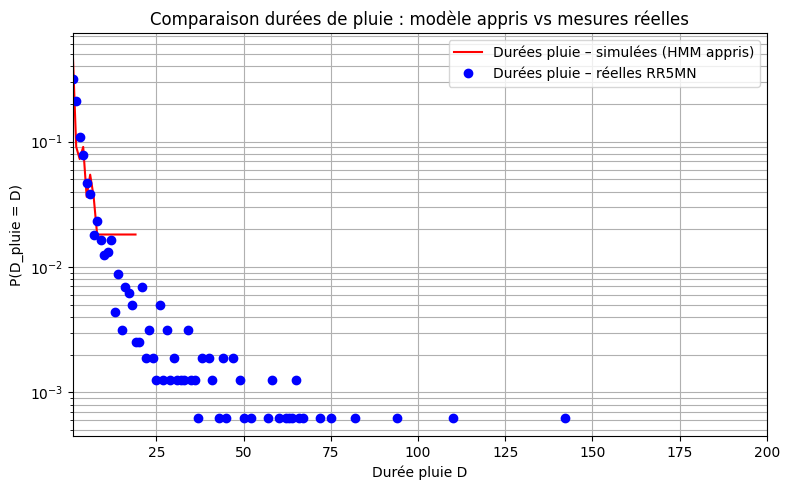

In [36]:
# -*- coding: utf-8 -*-
"""
Exercice 2 – Question 3
Ajustement du HMM 3 états (Clear / Cloudy / Very Cloudy)
sur la série expérimentale RR5MN avec Baum-Welch.
"""

import numpy as np
import scipy.io.matlab as mio
from pomegranate.distributions import Categorical
from pomegranate.hmm import DenseHMM
import matplotlib.pyplot as plt

# ============================================================
# 1. Chargement de la série expérimentale (RR5MN)
# ============================================================

# Fichier de mesures binaires : 0 = sec, 1 = pluie
ObsMesure = mio.loadmat('../data/RR5MN.mat')['Support'].astype(np.int8).squeeze() - 1

# ============================================================
# 2. Définition du HMM initial à 3 états
#    E0 = Clear Sky, E1 = Cloudy, E2 = Very Cloudy
# ============================================================

T_init = np.array([
    [0.9,  0.1,  0.0],
    [0.5,  0.4,  0.1],
    [0.0,  0.35, 0.65]
], dtype=np.float32)

B_init = np.array([
    [1.0, 0.0],
    [0.8, 0.2],
    [0.0, 1.0]
], dtype=np.float32)

pi0_init = np.array([0.5, 0.4, 0.1], dtype=np.float32)

# Distributions d’émission (une Categorical par état)
d0 = Categorical(np.array([B_init[0]], dtype=np.float32))
d1 = Categorical(np.array([B_init[1]], dtype=np.float32))
d2 = Categorical(np.array([B_init[2]], dtype=np.float32))

# Construction du modèle HMM (on passe les probabilités,
# le modèle les convertit en log en interne)
model = DenseHMM(
    [d0, d1, d2],
    edges=T_init,
    starts=pi0_init,
    ends=np.array([1e-20, 1e-20, 1e-20], dtype=np.float32),
    sample_length=10000,
    return_sample_paths=True,
)

print("=== MATRICES INITIALES ===")
print("Matrice de transition initiale T :\n", T_init)
print("Matrice d'émission initiale B :")
print("  Etat E0 (Clear Sky)  :", B_init[0])
print("  Etat E1 (Cloudy)     :", B_init[1])
print("  Etat E2 (VeryCloudy) :", B_init[2])

# ============================================================
# 3. Apprentissage des paramètres par Baum-Welch sur les
#    100 000 premières observations
# ============================================================

# X doit être de forme (n_sequences, longueur, 1)
X = np.reshape(ObsMesure[:100000], (1, -1, 1)).astype(np.int64)

# Ajustement des paramètres du HMM
model.fit(X)
#model.ends[:] = np.array([1e-8, 1e-8, 1e-8], dtype=np.float64)
# On remet les probas de fin très petites pour ne pas arrêter la chaîne
try:
    # If model.ends is a numpy array-like
    model.ends[0] = -46.0
    model.ends[1] = -46.0
    model.ends[2] = -46.0
except Exception:
    # If ends is a torch Parameter, set in-place if possible
    try:
        model.ends.data.fill_(-46.0)
    except Exception:
        # last resort: assign a compatible object
        import torch
        model.ends = torch.nn.Parameter(torch.tensor([-46.0, -46.0, -46.0]))

# ============================================================
# 4. Affichage des matrices après apprentissage
# ============================================================

print("\n=== MATRICES APRES BAUM-WELCH ===")

# Matrice de transition apprise (edges est en log, on fait exp())
try:
    T_learned = model.edges.exp().detach().numpy() if hasattr(model.edges, "detach") else model.edges.exp()
except Exception:
    # fallback for other types
    try:
        import torch
        T_learned = torch.exp(model.edges).detach().cpu().numpy()
    except Exception:
        T_learned = np.exp(model.edges)

print("Matrice de transition apprise T* :\n", T_learned)

# Matrices d’émission apprises
# (les distributions d0, d1, d2 ont été mises à jour par fit())
print("\nMatrice d'émission apprise B* :")
print("  Etat 0 (ex-Clear Sky)  :", d0.probs)
print("  Etat 1 (ex-Cloudy)     :", d1.probs)
print("  Etat 2 (ex-VeryCloudy) :", d2.probs)

# ============================================================
# 5. Exemple : génération d'une nouvelle séquence à partir
#    du modèle appris (optionnel)
# ============================================================

# Sample once (use whatever length is returned)
res = model.sample(1)
if isinstance(res, (tuple, list)):
    obsSeq_new = res[0]
    statesSeq_new = res[1] if len(res) > 1 else None
else:
    obsSeq_new = res
    statesSeq_new = None

# Safely convert and extract observations
def _to_numpy(x):
    try:
        import torch as _torch
        if isinstance(x, _torch.Tensor):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.array(x)

obs_np = _to_numpy(obsSeq_new)
if obs_np.ndim == 3:
    obsSeq_new = obs_np[0][:, 0]
elif obs_np.ndim == 2:
    obsSeq_new = obs_np[0]
else:
    obsSeq_new = obs_np

if statesSeq_new is not None:
    states_np = _to_numpy(statesSeq_new)
    if states_np.ndim == 2:
        statesSeq_new = states_np[0]

print("\nExemple : premières valeurs de la séquence générée après apprentissage :")
print("  Observations (sec/pluie) :", obsSeq_new[:20])
print("  Etats cachés             :", (statesSeq_new[:20] if statesSeq_new is not None else 'N/A'))

from duree import duree

# 1. Générer une longue séquence simulée avec le HMM appris (use returned length)
Nsamples_new = 20000
res_sim = model.sample(1)
if isinstance(res_sim, (tuple, list)):
    obs_new = res_sim[0]
    states_new = res_sim[1] if len(res_sim) > 1 else None
else:
    obs_new = res_sim
    states_new = None

obs_new = _to_numpy(obs_new)
if obs_new.ndim == 3:
    obs_new = obs_new[0][:, 0]
elif obs_new.ndim == 2:
    obs_new = obs_new[0]

# 2. Extraire les durées pluie / sécheresse sur la séquence simulée
try:
    dSec_sim, dPluie_sim, pdfSec_sim, pdfPluie_sim, binsSec_sim, binsPluie_sim = duree(obs_new)
except Exception:
    # If duree returns only durations, adapt
    try:
        dSec_sim, dPluie_sim = duree(obs_new)
        pdfSec_sim = pdfPluie_sim = binsSec_sim = binsPluie_sim = None
    except Exception:
        dSec_sim = dPluie_sim = np.array([])
        pdfSec_sim = pdfPluie_sim = binsSec_sim = binsPluie_sim = None

# 3. Extraire les durées sur les données réelles
try:
    dSec_real, dPluie_real, pdfSec_real, pdfPluie_real, binsSec_real, binsPluie_real = duree(ObsMesure)
except Exception:
    try:
        dSec_real, dPluie_real = duree(ObsMesure)
        pdfSec_real = pdfPluie_real = binsSec_real = binsPluie_real = None
    except Exception:
        dSec_real = dPluie_real = np.array([])
        pdfSec_real = pdfPluie_real = binsSec_real = binsPluie_real = None

# 4. Construire les distributions discrètes (propre)
vals_sim, counts_sim = (np.unique(dPluie_sim, return_counts=True) if len(dPluie_sim)>0 else (np.array([]), np.array([])))
pdf_sim = (counts_sim / counts_sim.sum()) if counts_sim.size>0 else np.array([])

vals_real, counts_real = (np.unique(dPluie_real, return_counts=True) if len(dPluie_real)>0 else (np.array([]), np.array([])))
pdf_real = (counts_real / counts_real.sum()) if counts_real.size>0 else np.array([])

# 5. Tracé comparatif en échelle semi-log
plt.figure(figsize=(8,5))
if vals_sim.size>0:
    plt.semilogy(vals_sim, pdf_sim, 'r-', label="Durées pluie – simulées (HMM appris)")
if vals_real.size>0:
    plt.semilogy(vals_real, pdf_real, 'bo', label="Durées pluie – réelles RR5MN")

plt.xlabel("Durée pluie D")
plt.ylabel("P(D_pluie = D)")
plt.title("Comparaison durées de pluie : modèle appris vs mesures réelles")
plt.grid(True, which="both")
plt.legend()
plt.xlim(1, 200)  # pour lisibilité
plt.tight_layout()
plt.show()
